# HW1. Оценки и доверительные интервалы
#### Ильичёв А.С., 693

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

%matplotlib inline

## Задача 3

В качестве распределения с конечным вторым моментом возьмем $Beta(\alpha, \beta)$, $\alpha = 9, \beta = 41$. Сгенерируем 5 выборок и исследуем поведение статистики $T_n$ на них в зависимости от $n$.

In [2]:
beta_dist = sts.beta(a=11, b=39)
N = 50000
ns = np.arange(5, N, 10)

In [3]:
def tn(sample):
    n = len(sample)
    return ((sample.sum() - n * beta_dist.mean()) 
            / (beta_dist.std() * np.sqrt(n)))

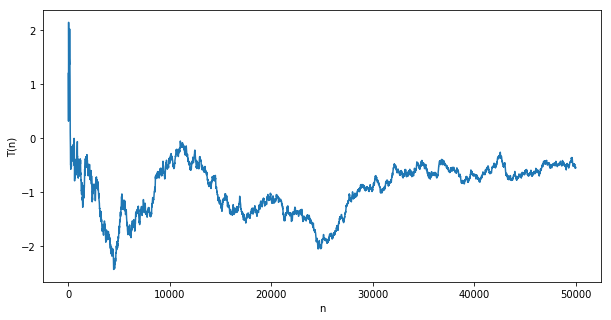

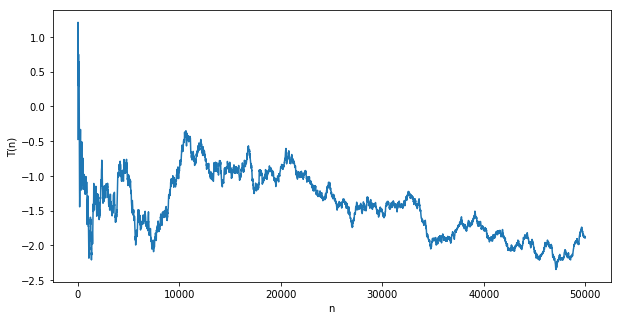

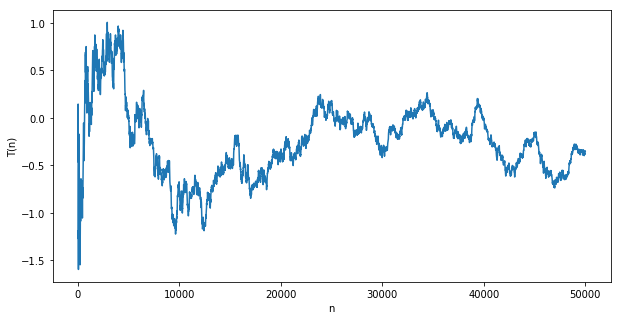

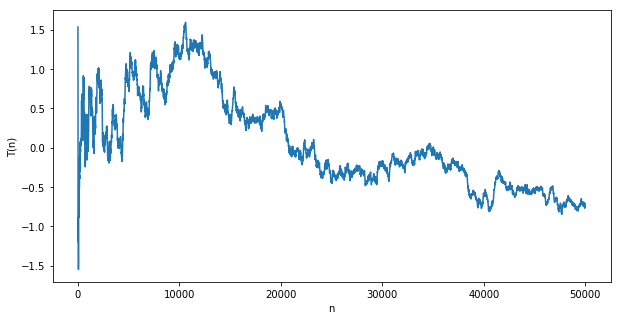

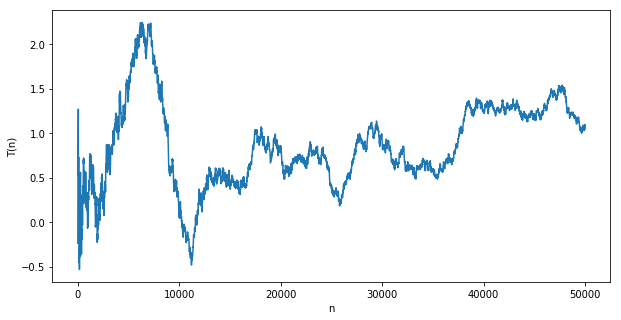

In [4]:
for i in range(5):
    sample = beta_dist.rvs(N)
    t_vals = [tn(sample[:n]) for n in ns]
    plt.figure(figsize=(10, 5))
    plt.plot(ns, t_vals)
    plt.xlabel('n')
    plt.ylabel('T(n)')
    plt.show()

Очевидной сходимости ни на одной из реализаций не наблюдается. 
По ЦПТ: 
$$
T_n = \frac{\sum_1^nX_i - nEX_1}{\sqrt{nDX_1}} = \frac{n(\overline{X} - EX_1)}{\sqrt{nDX_1}} = \sqrt{n}\frac{(\overline{X} - EX_1)}{\sqrt{DX_1}} \overset{d}{\longrightarrow} N(0,1).
$$
То есть $T_n$ стремится по распределению к стандартной нормальной случайной величине. Эта величина принимает некое значение, зависящее от предельной бесконечной выборки. Однако бесконечная выборка не определяется первыми $n$ членами, так что с ростом $n$ значение предельной величины меняется произвольным образом (вместе с выборкой), этим и объясняется вид графиков при больших $n$ (колебания в пределах нормального распределения).

## Задача 4


Построим сетку для $\alpha$.

In [5]:
num = 1000
alphas = np.linspace(10 / num, 5, num - 2, endpoint=False)

Получим выражение для доверительного интервала, используя метод центральной статистики.
$$
P(x^\alpha \le y) = P(x \le y^{1/\alpha}) = \int_1^{y^{1/\alpha}}\frac\alpha{x^{\alpha+1}}dx = 1 - 1/y
$$

$$
F_c(y) = P(X_{(n)}^\alpha \le y) = (1 - 1/y)^n
$$

$$
P(u_{(1-\gamma)/2} \le X_{(n)}^\alpha \le u_{(1+\gamma)/2}) = \gamma \text{, где $u_p$ - $p$-квантиль $F_c$. Находя квантили из условия $F_c(u_p) = p$ и логарифмируя, получаем:}
$$

$$
-\frac{\log{(1 - \sqrt[n]{(1-\gamma)/2})}}{\log X_{(n)}} \le \alpha \le -\frac{\log{(1 - \sqrt[n]{(1+\gamma)/2})}}{\log X_{(n)}}
$$

In [6]:
def plot_CI(lefts, rights, alphas, lim=None):
    plt.plot(alphas, lefts, c='black', linewidth=0.5)
    plt.plot(alphas, rights, c='black', linewidth=0.5)
    plt.fill_between(alphas, lefts, rights,
                     color='lightgrey', label=r'ДИ для $\alpha$')
    plt.plot(alphas, alphas, 
             '--', c='red', label=r'Истинное значение $\alpha$')
    plt.legend()
    plt.xlabel(r'$n$')
    if lim:
        plt.ylim(lim[0], lim[1])
        plt.show()
    

def left(x, gamma):
    n = len(x)
    return -(np.log(1 - ((1 - gamma) / 2) ** (1 / n)) 
             / np.log(np.max(x)))

def right(x, gamma):
    n = len(x)
    return -(np.log(1 - ((1 + gamma) / 2) ** (1 / n)) 
             / np.log(np.max(x)))
    

Пусть уровень доверия $\gamma = 0.95$, выведем доверительные интервалы в зависимости от $\alpha$.

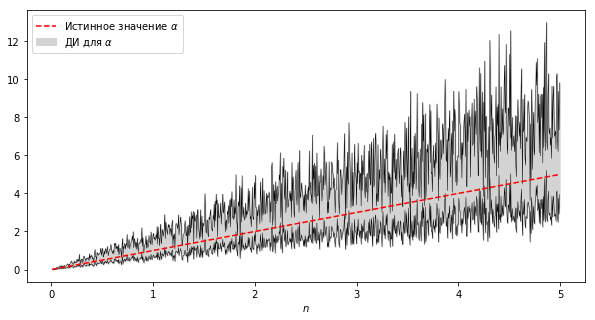

In [7]:
plt.figure(figsize=(10, 5))
lefts = []
rights = []
gamma = 0.95
for alpha in alphas:
    sample = sts.pareto(b=alpha).rvs(100)
    lefts.append(left(sample, gamma))
    rights.append(right(sample, gamma))
plot_CI(lefts, rights, alphas)

Доверительные интервалы довольно широкие и  ширина  интервала увеличивается с ростом $\alpha$ (то есть зависит от параметра распределения). На графике границы интервала могут сильно отличаться даже для близких значений параметра; это, скорее всего, происходит из-за того, что статистика $X_{(n)}$ достаточно сильно зависит от конкретной реализации выборки. Истинное значение $\alpha$ почти всегда попадает в интервал, как и должно быть при высоком уровне доверия.

## Задача 5


Зададим распределение, унаследовав базовый класс.

In [22]:
def weib_cdf(a, b, x):
    return 1 - np.exp(-np.power(b*x, a)) if x>0 else 0

class Weibull(sts.rv_continuous):
    def _cdf(self, x):
        return weib_cdf(11, 39, x)

In [23]:
weib_dist = Weibull()
sample = weib_dist.rvs(size=100)

Реализуем метод спейсингов и найдем оценку параметров.

In [24]:
from scipy.optimize import minimize

sorted_sample = sorted(sample)
def spacing_func(params):
    x = [0] + sorted_sample + [np.inf]
    ds = [weib_cdf(params[0], params[1], x[i + 1])
          - weib_cdf(params[0], params[1], x[i])
          for i in range(len(x) - 1)]
    return -np.sum(np.log(ds)) # minus for minimizing

res = minimize(spacing_func, [8, 20], method='COBYLA') 

In [25]:
res

     fun: 535.4719186922102
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 81
  status: 1
 success: True
       x: array([11.5502024 , 38.89106731])

Параметры близки к заданным. Однако из-за больших значений параметров градиент функции распределения очень велик, поэтому не все методы оптимизации хорошо справляются с задачей.

## Задача 6


In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('Aids2.csv')

In [14]:
df.head()

,state,sex,diag,death,status,categ,age
0,NSW,M,10905,11081,D,hs,35
1,NSW,M,11029,11096,D,hs,53
2,NSW,M,9551,9983,D,hs,42
3,NSW,M,9577,9654,D,haem,44
4,NSW,M,10015,10290,D,hs,39


Получим целевую переменную.

In [15]:
df['y'] = df['death'] - df['diag']

Сгенерируем выборку.

In [29]:
alpha = 1
N = 1000
par_sample = sts.pareto(b=alpha).rvs(N)

In [30]:
def Pickand(sample, k, sort=True):
    if sort:
        x = sorted(sample)
    else:
        x = sample
    n = len(x)
    m = n - 1 # for convenience
    return (np.log((x[m - k] - x[m - 2 * k])
                    / (x[m - 2 * k] - x[m - 4 * k]))
            / np.log(2))

def Hill(sample, k, sort=True):
    if sort:
        x = sorted(sample)
    else:
        x = sample
    n = len(x)
    m = n - 1 # for convenience
    return (np.sum([np.log(x[m - i]) - np.log(x[m - k])
                    for i in range(k)]) / k)

Фиксируем $n$ (несколько) и построим график зависимости статистик от $k$.

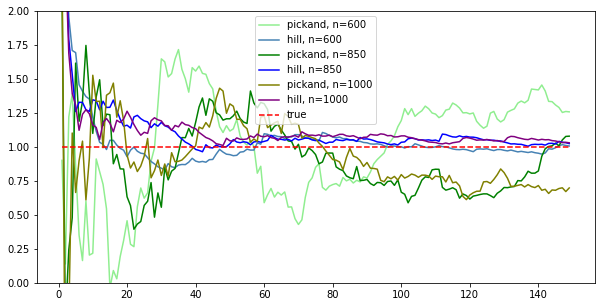

In [31]:
ns = [600, 850, 1000]
ks = np.arange(1, 150)
plt.figure(figsize=(10, 5))
colors = [['lightgreen', 'green', 'olive'],
          ['steelblue', 'blue', 'purple']]
for i, n in enumerate(ns):
    hills = [Hill(par_sample[:n], k) for k in ks]
    pickands = [Pickand(par_sample[:n], k) for k in ks]
    plt.plot(ks, pickands, c=colors[0][i], label='pickand, n='+str(n))
    plt.plot(ks, hills, c=colors[1][i], label='hill, n='+str(n))
plt.plot([ks[0], ks[-1]], [1/alpha, 1/alpha], '--', c='red', label='true')
plt.legend()
plt.ylim(0, 2)
plt.show()

Видно, что оценка Хилла (синие цвета) ведет себя лучше, чем оценка Пиканда (зеленые цвета). Ее значение почти не зависит как  от выбора $k > \approx 20$, так и от размера выборки, и близко к реальному значению индекса (1). Оценка Пиканда же сильно меняет свое поведение в зависимости от этих параметров и колеблется в большом диапазоне.

Попробуем определить наилучшее значение $k$ для оценки Пикарда, для этого сгенерируем много выборок и построим график зависимости оценки от $k$.

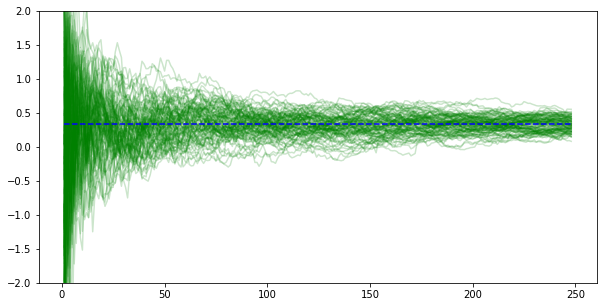

In [19]:
alpha = 3
n_samples = 100
ks = np.arange(1, 249)
plt.figure(figsize=(10, 5))
for i in range(n_samples):
    sample = sts.pareto(b=alpha).rvs(N)
    pickands = [Pickand(sample, k) for k in ks]
    plt.plot(ks, pickands, c='green', alpha=0.2)
plt.plot([ks[0], ks[-1]], [1/alpha, 1/alpha], '--', c='blue')
plt.ylim(-2,2)
plt.show()

Кажется, что для оценки Пиканда чем больше $k$, тем лучше. При максимально возможном $k = n/4$ оценка близка к истинному значению и слабее всего зависит от выборки.

Определим значение индекса экстремального значения по датасету. Для этого опять построим графики зависимости оценки от $k$.

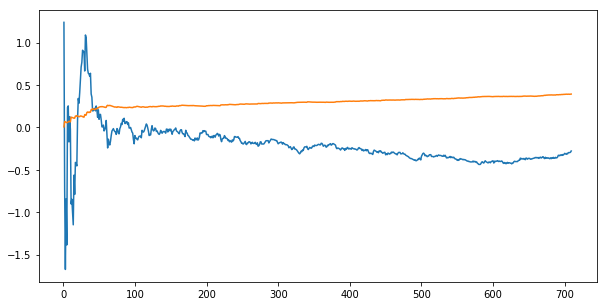

In [20]:
n_df = len(df)
ks = np.arange(1, int((n_df - 3)/4))
df_sorted = sorted(df['y']) 
ests_p = [Pickand(df_sorted, k, sort=False) for k in ks]
ests_h = [Hill(df_sorted, k, sort=False) for k in ks]
plt.figure(figsize=(10, 5))
plt.plot(ks, ests_p, label='pickand')
plt.plot(ks, ests_h, label='hill')
plt.show()

По этим графикам сложно не определить. Вспомним из лекции, что оценка Хилла для распределения Парето наименее смещенная при малых $k$, и построим оценку для малых $k$.

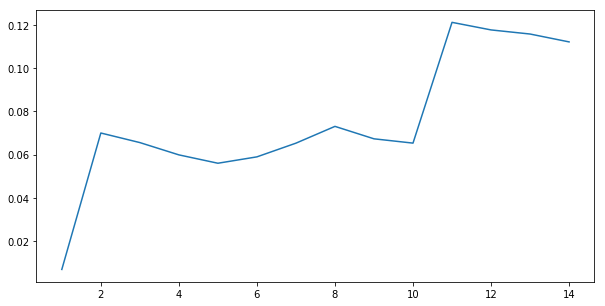

In [21]:
ks = np.arange(1, 15)
ests_h = [Hill(df_sorted, k, sort=False) for k in ks]
plt.figure(figsize=(10, 5))
plt.plot(ks, ests_h, label='hill')
plt.show()

Видим  участок, на котором оценка слабо меняется. Предполагая несмещенность, можно заключить, что истинное значение индекса примерно $0.06$. 